<a href="https://colab.research.google.com/github/SachinScaler/Apr24_TimeSeries_and_RecSys/blob/main/ML_End_to_end_Practical_Session%7CLecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Content

- Regressor
- Matrix Factorization from Scatch
- Matrix Factorization using Library
- Performance Evaluation Metric

In [1]:
# Import Libraries
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

#### Let's download the dataset

In [2]:
!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1Q9UJtrN_v_dS-garl5gQ1I_SotGhye_1' -O "movies.csv"
!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1HOFWUAMFlYbd-gk1B2IyV2-hXDZI7gKR' -O "ratings.csv"
!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1b7_yRRBs3s3atp1WQHN2GU577vxY8u_h' -O "users.csv"

--2024-05-11 16:32:10--  https://drive.google.com/uc?export=download&id=1Q9UJtrN_v_dS-garl5gQ1I_SotGhye_1
Resolving drive.google.com (drive.google.com)... 173.194.193.101, 173.194.193.102, 173.194.193.139, ...
Connecting to drive.google.com (drive.google.com)|173.194.193.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1Q9UJtrN_v_dS-garl5gQ1I_SotGhye_1&export=download [following]
--2024-05-11 16:32:10--  https://drive.usercontent.google.com/download?id=1Q9UJtrN_v_dS-garl5gQ1I_SotGhye_1&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 108.177.120.132, 2607:f8b0:4001:c18::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|108.177.120.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 515699 (504K) [application/octet-stream]
Saving to: ‘movies.csv’

movies.csv          100%[===================>] 503.61K  --.-KB/

In [3]:
# Loading Data
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')
users = pd.read_csv('users.csv')

In [4]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,16,4.0,1217897793
1,1,24,1.5,1217895807
2,1,32,4.0,1217896246
3,1,47,4.0,1217896556
4,1,50,4.0,1217896523


In [6]:
users.head()

,userId,age,time_spent_per_day
0,1,16,3.976315
1,2,24,1.891303
2,3,20,4.521478
3,4,23,2.095284
4,5,35,1.759860


#### Let's Filter the data with most frequently rated movies by counting the number of ratings for each movie and selecting the top 1000 movies with the highest rating counts.

In [7]:
ratings.movieId.value_counts().head(1000)

movieId
296      325
356      311
318      308
480      294
593      290
        ... 
55276     26
546       26
5872      26
2528      26
7502      26
Name: count, Length: 1000, dtype: int64

In [8]:
select_movies = ratings.movieId.value_counts().head(1000).index.to_list()
len(select_movies)

1000

In [9]:
# Let's filter the select Movies
movies = movies.loc[movies.movieId.isin(select_movies)]
ratings = ratings.loc[ratings.movieId.isin(select_movies)]

### Transforming Movie Genres into Binary Features
- Let's Split and create OHE Columns from Genre String

In [10]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller


In [11]:
m = movies.copy()
m['genres'] = m['genres'].str.split('|')
m['genres']

0        [Adventure, Animation, Children, Comedy, Fantasy]
1                           [Adventure, Children, Fantasy]
2                                        [Comedy, Romance]
4                                                 [Comedy]
5                                [Action, Crime, Thriller]
                               ...                        
9908                                       [Comedy, Drama]
9914                                        [Sci-Fi, IMAX]
9975                                [Action, Sci-Fi, IMAX]
10005                          [Action, Adventure, Sci-Fi]
10089                               [Drama, Thriller, War]
Name: genres, Length: 1000, dtype: object

In [12]:
m = m.explode('genres')
m

,movieId,title,genres
0,1,Toy Story (1995),Adventure
0,1,Toy Story (1995),Animation
0,1,Toy Story (1995),Children
0,1,Toy Story (1995),Comedy
0,1,Toy Story (1995),Fantasy
...,...,...,...
10005,112852,Guardians of the Galaxy (2014),Adventure
10005,112852,Guardians of the Galaxy (2014),Sci-Fi
10089,116797,The Imitation Game (2014),Drama
10089,116797,The Imitation Game (2014),Thriller


In [13]:
m = m.pivot(index='movieId', columns='genres', values='title')
m

genres,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieId,,,,,,,,,,,,,,,,,,,
1,NaN,Toy Story (1995),Toy Story (1995),Toy Story (1995),Toy Story (1995),NaN,NaN,NaN,Toy Story (1995),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,Jumanji (1995),NaN,Jumanji (1995),NaN,NaN,NaN,NaN,Jumanji (1995),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,Grumpier Old Men (1995),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Grumpier Old Men (1995),NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,Father of the Bride Part II (1995),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Heat (1995),NaN,NaN,NaN,NaN,Heat (1995),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Heat (1995),NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109374,NaN,NaN,NaN,NaN,"Grand Budapest Hotel, The (2014)",NaN,NaN,"Grand Budapest Hotel, The (2014)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
109487,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Interstellar (2014),NaN,NaN,NaN,Interstellar (2014),NaN,NaN,NaN
111759,Edge of Tomorrow (2014),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Edge of Tomorrow (2014),NaN,NaN,NaN,Edge of Tomorrow (2014),NaN,NaN,NaN


In [14]:
m = ~m.isna()
m = m.astype(int)
m

genres,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieId,,,,,,,,,,,,,,,,,,,
1,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109374,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
109487,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
111759,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0


### Let's Extract Hour from Timestamp

 - Extracting the hour from the timestamp can indeed serve as a valuable user feature.
 - By incorporating the hour of the day when users provide ratings, it provides a means to capture time-based patterns and behaviors of users.

In [15]:
r = ratings.copy()
r.info()

<class 'pandas.core.frame.DataFrame'>
Index: 63250 entries, 0 to 105252
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   userId     63250 non-null  int64  
 1   movieId    63250 non-null  int64  
 2   rating     63250 non-null  float64
 3   timestamp  63250 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 2.4 MB


In [16]:
r.tail()

,userId,movieId,rating,timestamp
105148,668,109374,4.0,1415763807
105151,668,109487,4.0,1415421771
105185,668,111759,3.0,1413728719
105205,668,112852,4.0,1433992065
105252,668,116797,4.0,1422970740


In [17]:
x = 1422970740
datetime.fromtimestamp(x).hour

13

In [18]:
datetime.fromtimestamp(x).day

3

In [19]:
datetime.fromtimestamp(x).month

2

In [20]:
datetime.fromtimestamp(x).year

2015

In [21]:
r['hour'] = r['timestamp'].apply(lambda x: datetime.fromtimestamp(x).hour)
r.head()

,userId,movieId,rating,timestamp,hour
0,1,16,4.0,1217897793,0
1,1,24,1.5,1217895807,0
2,1,32,4.0,1217896246,0
3,1,47,4.0,1217896556,0
4,1,50,4.0,1217896523,0


### Now, Let's Read and Merge User Data with Aggregated Values:

In [22]:
users = pd.read_csv('users.csv')
users.head()

,userId,age,time_spent_per_day
0,1,16,3.976315
1,2,24,1.891303
2,3,20,4.521478
3,4,23,2.095284
4,5,35,1.759860


In [23]:
users = users.merge(r.groupby('userId').rating.mean().reset_index(), on='userId')
users = users.merge(r.groupby('userId').hour.mean().reset_index(), on='userId')
users.head()

,userId,age,time_spent_per_day,rating,hour
0,1,16,3.976315,3.691589,0.000000
1,2,24,1.891303,3.923077,16.000000
2,3,20,4.521478,3.806452,9.000000
3,4,23,2.095284,4.159420,2.057971
4,5,35,1.759860,2.864865,19.000000


### Homework:
Now we have enough info to create the user-user similarity matrix and item-item similarity matrix, which is movie genre data and Build Content Based RecSys.

HINT:

In [24]:
users.shape

(668, 5)

In [25]:
users

,userId,age,time_spent_per_day,rating,hour
0,1,16,3.976315,3.691589,0.000000
1,2,24,1.891303,3.923077,16.000000
2,3,20,4.521478,3.806452,9.000000
3,4,23,2.095284,4.159420,2.057971
4,5,35,1.759860,2.864865,19.000000
...,...,...,...,...,...
663,664,22,5.288101,3.964286,16.000000
664,665,20,5.220446,3.553763,12.086022
665,666,19,3.262313,3.642857,8.111111
666,667,17,3.674356,3.807692,14.707692


In [26]:
m

genres,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieId,,,,,,,,,,,,,,,,,,,
1,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109374,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
109487,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
111759,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0


In [27]:
r

,userId,movieId,rating,timestamp,hour
0,1,16,4.0,1217897793,0
1,1,24,1.5,1217895807,0
2,1,32,4.0,1217896246,0
3,1,47,4.0,1217896556,0
4,1,50,4.0,1217896523,0
...,...,...,...,...,...
105148,668,109374,4.0,1415763807,3
105151,668,109487,4.0,1415421771,4
105185,668,111759,3.0,1413728719,14
105205,668,112852,4.0,1433992065,3


In [28]:
u1 = users.iloc[300]
u1

userId                301.000000
age                    25.000000
time_spent_per_day      1.746663
rating                  4.011628
hour                   16.790698
Name: 300, dtype: float64

In [29]:
u1_vec = u1.values[1:]
u1_vec

array([25.        ,  1.74666311,  4.01162791, 16.79069767])

In [30]:
u2 = users.iloc[600]
u2

userId                601.000000
age                    23.000000
time_spent_per_day      5.087798
rating                  3.990000
hour                    9.680000
Name: 600, dtype: float64

In [31]:
u2_vec = u2.values[1:]
u2_vec

array([23.        ,  5.08779778,  3.99      ,  9.68      ])

In [32]:
def cosine_similarity(vec1, vec2):
  """
  Calculates the cosine similarity between two vectors.
  """
  vec1_norm = np.linalg.norm(vec1)
  vec2_norm = np.linalg.norm(vec2)
  if vec1_norm * vec2_norm == 0:
    return 0  # Avoid division by zero
  return round(np.dot(vec1, vec2) / (vec1_norm * vec2_norm),2)

In [33]:
cosine_similarity(u1_vec, u2_vec)

0.97

In [34]:
cosine_similarity(u1_vec, u1_vec)

1.0

Tasks:
- Built similar pipeline for Movie to Movie Content Based RecSys.

- Find top k similar users or movies to recommened

### For Now, let's build A Content Based Regression Model to Predict Ratings

#### How can we use this information to build the regressor?

> We know that **rating** is our target variable.


#### What should be our features?

**users:** userId, age, time_spent_per_day, avg_hour, avg_rating

**ratings:** movie_id

**movies:** Action, Adventure, Animation, Children, Comedy, Crime, Documentary,	Drama, Fantasy, Film-Noir, Horror, IMAX, Musical, Mystery, Romance, Sci-Fi,	Thriller,	War	Western

We'll use the above features from the respective data to build the regressor model.

Before that Let's Rescale the data

In [35]:
u = users.copy()
u = u.set_index('userId')
u.columns = ['age', 'time_spent_per_day', 'u_avg_rating', 'hour']

scaler = StandardScaler()
u = pd.DataFrame(scaler.fit_transform(u), columns=u.columns, index=u.index)
u.head(2)

,age,time_spent_per_day,u_avg_rating,hour
userId,,,,
1,-1.470292,0.341073,-0.073572,-1.900624
2,-0.135616,-1.079947,0.426461,0.610601


In [36]:
m.head()

genres,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieId,,,,,,,,,,,,,,,,,,,
1,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0


In [37]:
u.head()

,age,time_spent_per_day,u_avg_rating,hour
userId,,,,
1,-1.470292,0.341073,-0.073572,-1.900624
2,-0.135616,-1.079947,0.426461,0.610601
3,-0.802954,0.712624,0.174541,-0.488060
4,-0.302450,-0.940926,0.936982,-1.577622
5,1.699565,-1.169532,-1.859363,1.081456


 ### Creating Final Feature Matrix

 - Creating a merged DataFrame **X** by combining user and movie data with their respective ratings.
 - Selecting columns **movieId**, **userId**and **rating** from the ratings dataset, then merges this data with user information and movie information based on **userId** and **movieId** respectively.
 - The result is a combined dataset that includes user and movie attributes along with their ratings, providing a comprehensive basis for building recommendation models.

In [38]:
X = ratings[['movieId', 'userId', 'rating']].copy()
X = X.merge(u.reset_index(), on='userId', how='right')
X = X.merge(m.reset_index(), on='movieId', how='right')
X.head()

,movieId,userId,rating,age,time_spent_per_day,u_avg_rating,hour,Action,Adventure,Animation,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,2,5.0,-0.135616,-1.079947,0.426461,0.610601,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,5,4.0,1.699565,-1.169532,-1.859363,1.081456,0,1,1,...,0,0,0,0,0,0,0,0,0,0
2,1,8,5.0,0.364888,0.298545,0.160605,0.453650,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,1,11,4.0,-1.303458,0.513712,-0.380602,-0.424244,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,1,14,4.0,-0.302450,1.251552,-0.379415,-0.488060,0,1,1,...,0,0,0,0,0,0,0,0,0,0


#### Seperate Features and Target Variable


In [39]:
X = X.drop(columns = ['movieId', 'userId'])
y = X.pop('rating')

#### Train - Test Split

In [40]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#### Let's Build Regression Model

In [41]:
from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

#### Let's Calculate RMSE of Model on Test Set

In [42]:
from sklearn.metrics import mean_squared_error as mse

"RMSE:",mse(y_test, y_pred)**0.5

('RMSE:', 0.8868226507109813)

- On avg Predicted rating is off by 0.88 units from Actual Ratings.

## Question: Does Cold start problem occur with this model?


Can we still predict the ratings even if new user and movie is added?

In [43]:
user_info = u.loc[1].to_list()
user_info

[-1.4702924221370586,
 0.341073008940242,
 -0.07357184271521526,
 -1.900623708546779]

In [44]:
movie_info = m.loc[1].to_list()
movie_info

[0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [45]:
user1_movie1 = user_info+movie_info
user1_movie1

[-1.4702924221370586,
 0.341073008940242,
 -0.07357184271521526,
 -1.900623708546779,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [46]:
model.predict([user1_movie1]) # in our db 1000 movies, 10->990

array([3.70223883])

# Now Let's Try Matrix Factorization from Scratch

In [47]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,16,4.0,1217897793
1,1,24,1.5,1217895807
2,1,32,4.0,1217896246
3,1,47,4.0,1217896556
4,1,50,4.0,1217896523


In [48]:
rm = ratings.pivot(index = 'userId', columns ='movieId', values = 'rating').fillna(0)
rm.head()

movieId,1,2,3,5,6,7,10,11,16,17,...,88125,89745,91529,96610,99114,109374,109487,111759,112852,116797
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5.0,0.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,3.0,0.0,3.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


###  Selecting only 100 rows

In [51]:
rm_small = rm.copy()
rm_small = rm_small[rm_small.columns[:100]]
rm_small = rm_small.head(100)
rm_small

movieId,1,2,3,5,6,7,10,11,16,17,...,300,303,306,307,308,315,316,317,318,319
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
2,5.0,0.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,3.0,0.0,3.0,0.0,4.0,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.0,5.0,5.0,0.0,0.0,0.0,4.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,5.0,0.0,4.0,3.0,4.0,3.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,3.5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [57]:
(rm > 0).sum().sum() / (rm.shape[0] * rm.shape[1])

0.09468562874251497

In [58]:
rm.shape

(668, 1000)

In [55]:
rm_small.shape

(100, 100)

In [59]:
import time

# hiddendim
K = 2

# intializing using normal distribution
P = np.random.normal(size=(rm_small.shape[0], K))
Q = np.random.normal(size=(rm_small.shape[1], K))

# for logging purpose
start = time.time()

# model training
def matrix_factorization(R, P, Q, K, steps=10000, alpha=0.0002, beta=0.02):
    Q = Q.T
    for step in range(steps):
        for i in range(len(R)):
            for j in range(len(R[i])):
                if R[i][j] == 0:
                    continue
                eij = R[i][j] - np.dot(P[i,:],Q[:,j]) # calculate Residual
                for k in range(K):
                    P[i][k] += alpha * (2 * eij * Q[k][j]) # - lr *res*P[i][k])
                    Q[k][j] += alpha * (2 * eij * P[i][k]) # - lr *res*Q[k][j])
    return P, Q.T

# call the optimization function
P_, Q_ =  matrix_factorization(rm_small.values.copy(), P.copy(), Q.copy(), 2)

end = time.time()
print(f"Time Elapsed in trainig: {end-start}")

# Predicted Values vs Actual Ratings
print(np.dot(P_[4], Q_[36]), rm_small.values[4, 36])
print(np.dot(P_[1], Q_[0]), rm_small.values[1, 0])
print(np.dot(P_[1], Q_[2]), rm_small.values[1, 2])
print(np.dot(P_[3], Q_[17]), rm_small.values[3, 17])

Time Elapsed in trainig: -138.57909059524536
0.26693639012803594 0.5
4.39886206602639 5.0
3.131602550415807 2.0
4.571227262688081 5.0


In [60]:
from sklearn.metrics import mean_squared_error as mse

rm_ = np.dot(P_, Q_.T)
mse(rm_small.values[rm_small > 0], rm_[rm_small > 0])**0.5

0.6528565586463473

Looks Good for Performance with Just interaction Matrix

### Using cmfrec library

### Collective matrix factorisation for recommender systems
**Documentation:** https://cmfrec.readthedocs.io/en/latest/


- **cmfrec** library requires input in the form of dataframe not as sparse matrix.

- It required 3 columns UserId, ItemId, Rating.

- An instance of the CMF model is created with various hyperparameters:

 - **method="als":** Specifies the alternating least squares (ALS) optimization method, commonly used for matrix factorization in recommendation systems.

 - **k=2:** Sets the number of latent factors to 2, determining the dimensionality of the latent factor space.

 - **lambda_=0.1:** Sets the regularization strength to 0.1. Regularization is used to prevent overfitting in the model.

 - **user_bias=False:** Indicates that user bias terms are not included in the model. User bias represents a user's overall rating tendency.

 - **item_bias=False:** Excludes item bias terms in the model. Item bias represents an item's overall rating tendency.

 - **verbose=False:** Suppresses verbose output, controlling whether the model's training progress is displayed.



In [61]:
rm_raw = ratings[['userId', 'movieId', 'rating']].copy()
rm_raw.columns = ['UserId', 'ItemId', 'Rating']  # Lib requires specific column names
rm_raw.head()

,UserId,ItemId,Rating
0,1,16,4.0
1,1,24,1.5
2,1,32,4.0
3,1,47,4.0
4,1,50,4.0


In [62]:
!pip install cmfrec

In [63]:
from cmfrec import CMF

model = CMF(method="als", k=2, lambda_=0.1, user_bias=False, item_bias=False, verbose=False)

start = time.time()
model.fit(rm_raw)
end = time.time()
print(f"Time Elapsed in trainig: {end-start}")

Time Elapsed in trainig: 0.27275657653808594


In [64]:
model.A_.shape, model.B_.shape

((668, 2), (1000, 2))

In [66]:
rm_raw.Rating.mean(), model.glob_mean_

(3.6659130434782607, 3.6659131050109863)

#### Predictions and RMSE

In [67]:
rm__ = np.dot(model.A_, model.B_.T) + model.glob_mean_
mse(rm.values[rm > 0], rm__[rm > 0])**0.5

1.0629517113958387

In [69]:
# n: no of items to recommend
top_items = model.topN(user=10, n=10)
movies.loc[movies.movieId.isin(top_items)]

,movieId,title,genres
47,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
279,318,"Shawshank Redemption, The (1994)",Crime|Drama
695,858,"Godfather, The (1972)",Crime|Drama
733,912,Casablanca (1942),Drama|Romance
938,1172,Cinema Paradiso (Nuovo cinema Paradiso) (1989),Drama
973,1212,"Third Man, The (1949)",Film-Noir|Mystery|Thriller
5390,7502,Band of Brothers (2001),Action|Drama|War
6958,44555,"Lives of Others, The (Das leben der Anderen) (...",Drama|Romance|Thriller
7160,48516,"Departed, The (2006)",Crime|Drama|Thriller
9908,109374,"Grand Budapest Hotel, The (2014)",Comedy|Drama


### Calculating Average OverLap

avg_perc_overlap: 0.4179829890643985


<Axes: >

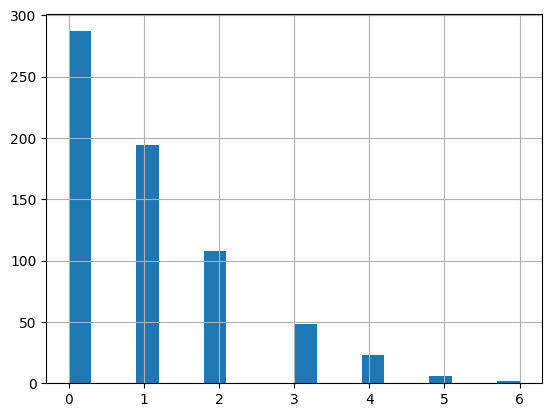

In [70]:
overlap= []
num_rec = []
n = 20
for user in ratings.userId.unique():
    top_items = model.topN(user=user, n=n)
    user_movies = ratings.loc[(ratings.userId==user)].movieId
    valid_rec = set(top_items).intersection(set(user_movies)) # I can only measure by what was in the training data

    _ = len(set(ratings.loc[ratings.userId==user].sort_values(by='rating', ascending=False).head(n).movieId).intersection(set(valid_rec)))
    overlap.append(_)
    num_rec.append(len(valid_rec))

print('avg_perc_overlap:', np.array(overlap).mean() / np.array(num_rec).mean())
pd.Series(overlap).hist(bins=20)

**K-precision**

### What is K-precision?

- K-Precision is a metric used to evaluate the quality of recommendations provided by recommendation systems.
- It assesses how many of the top-K recommended items are relevant to the user's preferences.
- A higher K-Precision value indicates better recommendation quality.

<center><img src="https://drive.google.com/uc?id=1DO8xfPMTT61g1lgFVpYd0DRqeQZuue-I"></center>


**Out of K predictions, how many of those K were relevant?**



avg: 0.7849889642782759


<Axes: >

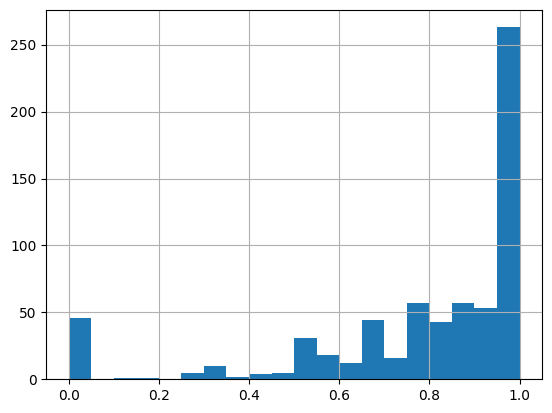

In [71]:
overlap=[]

for user in ratings.userId.unique():
    recommendations = model.topN(user=user, n=100)
    user_movies = ratings.loc[(ratings.userId==user)].movieId
    valid_rec = set(recommendations).intersection(set(user_movies)) # I can only measure by what was in the training data
    relevant_items = ratings.loc[(ratings.userId==user) & (ratings.rating>=4)].movieId
    try:
        _ = len(set(recommendations).intersection(set(relevant_items))) / len(valid_rec)
    except:
        _ = 0
    overlap.append(_)

overlap = np.array(overlap)
print('avg:', overlap.mean())
pd.Series(overlap).hist(bins=20)

**if I make, K predictions, how many relevant items was able to find?**

In [ ]:
# overlap=[]
# for user in ratings.userId.unique():
#     recommendations = model.topN(user=user, n=100)
#     user_movies = ratings.loc[(ratings.userId==user)].movieId
#     valid_rec = set(recommendations).intersection(set(user_movies)) # I can only measure by what was in the training data
#     relevant_items = ratings.loc[(ratings.userId==user) & (ratings.rating>=4)].movieId
#     try:
#         _ = len(set(recommendations).intersection(set(relevant_items))) / len(set(relevant_items))
#     except:
#         _ = 0
#     overlap.append(_)

# overlap = np.array(overlap)
# print('avg:', overlap.mean())
# pd.Series(overlap).hist(bins=20)